<a href="https://colab.research.google.com/github/manishmawatwal/DataScience/blob/main/Cyclone_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [73]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import re
import datetime as dt

In [5]:
# upload files on google colab drive
from google.colab import files
uploaded = files.upload()

Saving pacific.csv to pacific.csv


In [40]:
#import data
df = pd.read_csv('pacific.csv')
df.head

<bound method NDFrame.head of              ID                 Name  ...  High Wind SW  High Wind NW
0      EP011949              UNNAMED  ...          -999          -999
1      EP011949              UNNAMED  ...          -999          -999
2      EP011949              UNNAMED  ...          -999          -999
3      EP011949              UNNAMED  ...          -999          -999
4      EP011949              UNNAMED  ...          -999          -999
...         ...                  ...  ...           ...           ...
26132  EP222015               SANDRA  ...             0             0
26133  EP222015               SANDRA  ...             0             0
26134  EP222015               SANDRA  ...             0             0
26135  EP222015               SANDRA  ...             0             0
26136  EP222015               SANDRA  ...             0             0

[26137 rows x 22 columns]>

# Status can be the following types:
1. TD – Tropical cyclone of tropical depression intensity (< 34 knots)
2. TS – Tropical cyclone of tropical storm intensity (34-63 knots)
3. HU – Tropical cyclone of hurricane intensity (> 64 knots)
4. EX – Extratropical cyclone (of any intensity)
5. SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
6. SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
7. LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
8. WV – Tropical Wave (of any intensity)
9. DB – Disturbance (of any intensity)

In [41]:
#convert date column as datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [42]:
'''creating columns - Latitude Hemisphere and Longitude Hemisphere 
                      with code 0 = N, 1 = S and 0 = E, 1 = W '''
def hemisphere(coord):
    hem = re.findall(r'[NSWE]', coord)[0]
    if hem == 'N' or hem == 'E':
        return 0
    else:
        return 1

In [43]:
df['Latitude_Hemisphere'] = df['Latitude'].apply(hemisphere)
df['Longitude_Hemisphere'] = df['Longitude'].apply(hemisphere)
df['Latitude_Hemisphere'] = df['Latitude_Hemisphere'].astype('category')
df['Longitude_Hemisphere'] = df['Longitude_Hemisphere'].astype('category')

In [44]:
#converting the latitude and longitude column to numeric type
df['Latitude'] = df['Latitude'].apply(lambda x: re.match('[0-9]{1,3}.[0-9]{0,1}', x)[0])
df['Longitude'] = df['Longitude'].apply(lambda x:re.match('[0-9]{1,3}.[0-9]{0,1}',x)[0])

In [45]:
#show the count of missing values and fill them with mean
for column in df.columns:
    missing_cnt = df[column][df[column] == -999].count()
    print('Missing Values in column {col} = '.format(col = column), missing_cnt)
    if missing_cnt != 0:
        mean = round(df[column][df[column] != -999].mean())
        index = df.loc[df[column] == -999, column].index
        df.loc[df[column] == -999, column] = mean

Missing Values in column ID =  0
Missing Values in column Name =  0
Missing Values in column Date =  0
Missing Values in column Time =  0
Missing Values in column Event =  0
Missing Values in column Status =  0
Missing Values in column Latitude =  0
Missing Values in column Longitude =  0
Missing Values in column Maximum Wind =  0
Missing Values in column Minimum Pressure =  12804
Missing Values in column Low Wind NE =  19750
Missing Values in column Low Wind SE =  19750
Missing Values in column Low Wind SW =  19750
Missing Values in column Low Wind NW =  19750
Missing Values in column Moderate Wind NE =  19750
Missing Values in column Moderate Wind SE =  19750
Missing Values in column Moderate Wind SW =  19750
Missing Values in column Moderate Wind NW =  19750
Missing Values in column High Wind NE =  19750
Missing Values in column High Wind SE =  19750
Missing Values in column High Wind SW =  19750
Missing Values in column High Wind NW =  19750
Missing Values in column Latitude_Hemisp

In [46]:
# restructing the dataframe for visibility and remove columns ID and Event
df = df[['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude', 'Latitude_Hemisphere', 'Longitude', 'Longitude_Hemisphere' ,'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']]

In [47]:
# changing all time to format HHMM
df['Time'] = df['Time'].astype('object')
def hhmm(time):
    time = str(time)
    digits = re.findall(r'\d', time)
    t = ''
    if len(digits) == 1:
        t = '0{i}00'.format(i = time)
    elif len(digits) == 2:
        t = '{i}00'.format(i = time)
    elif len(digits) == 3:
        t = '0{i}'.format(i = time)
    else:
        t = time
    return t

In [48]:
# apply the function
df['Time'] = df['Time'].apply(hhmm)
#convert the column into Datetime
df['Time'] = pd.to_datetime(df['Time'], format='%H%M').dt.time
#convert the status column to categorical
df['Status'] = df['Status'].astype('category')
data = df.drop(columns = ['ID', 'Event'])

In [49]:
data.head(10)

,Name,Date,Time,Status,Latitude,Latitude_Hemisphere,Longitude,Longitude_Hemisphere,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,UNNAMED,1949-06-11,00:00:00,TS,20.2,0,106.3,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
1,UNNAMED,1949-06-11,06:00:00,TS,20.2,0,106.4,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
2,UNNAMED,1949-06-11,12:00:00,TS,20.2,0,106.7,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
3,UNNAMED,1949-06-11,18:00:00,TS,20.3,0,107.7,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
4,UNNAMED,1949-06-12,00:00:00,TS,20.4,0,108.6,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
5,UNNAMED,1949-06-12,06:00:00,TS,20.5,0,109.4,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
6,UNNAMED,1949-06-12,12:00:00,TS,20.6,0,110.2,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
7,UNNAMED,1949-06-17,12:00:00,TS,14.1,0,107.0,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
8,UNNAMED,1949-06-17,18:00:00,TS,14.6,0,107.7,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5
9,UNNAMED,1949-06-18,00:00:00,TS,15.0,0,108.4,1,45,995,40,35,27,35,13,11,9,11,5,4,3,5


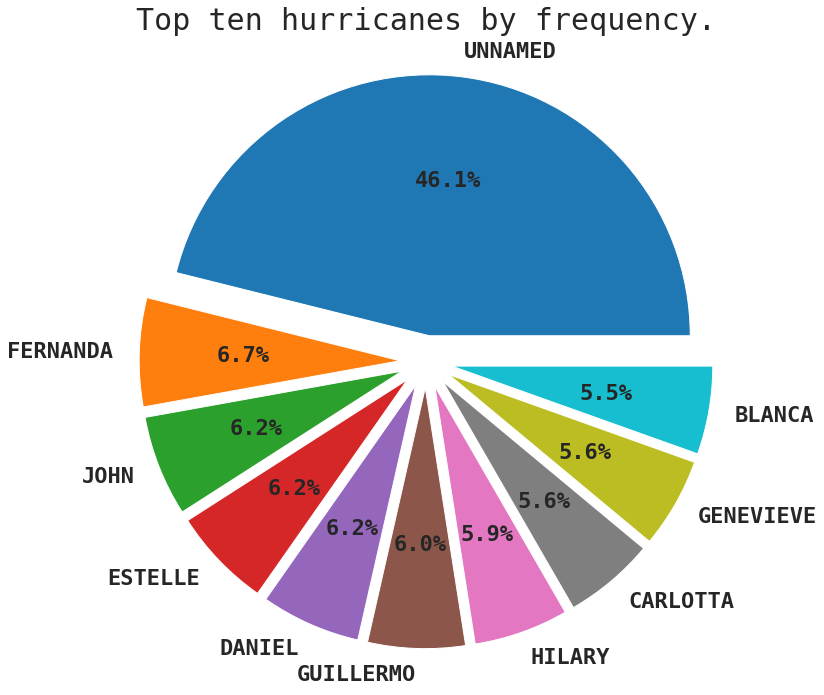

In [74]:
#top ten cyclones which occured the maximum number of times
lst = [x.strip() for x in data.groupby('Name').count().sort_values(by = 'Date', ascending = False).index[:10]]
val = data.groupby('Name').count().sort_values(by = 'Date', ascending = False)[:10]['Date'].values
font = {'family': 'monospace',
        'weight': 'bold',
        'size'  : 22}
plt.rc('font', **font)
fig, ax=plt.subplots()
fig.set_size_inches(12,12)
ax.pie(labels = lst, x = val, autopct = '%.1f%%', explode = [0.1 for x in range(10)])
plt.title('Top ten hurricanes by frequency.', fontsize = 30)
plt.show()

Text(0.5, 1.0, 'Frequency of Cyclones by Month.')

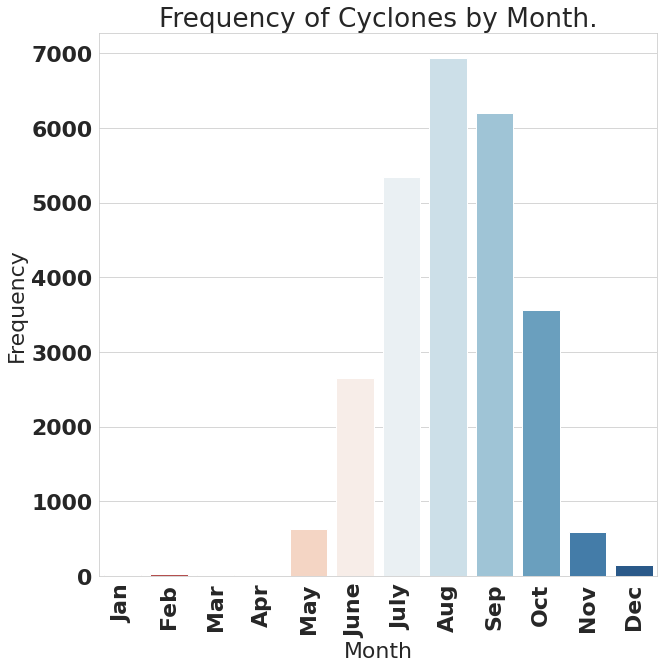

In [69]:
# frequency of hurricanes by month
data['Month'] = data['Date'].apply(lambda x: x.month)
data['Year'] = data['Date'].apply(lambda x: x.year)
mnt = ['Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'June' , 'July' , 'Aug' , 'Sep','Oct' , 'Nov' , 'Dec']
temp = data.groupby('Month').count()
temp.loc[4] = 0
temp = temp.sort_values(by = 'Month' , ascending = False)
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.figure(figsize = (10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x = temp.index , y = 'Date' , data=temp , palette = 'RdBu' )
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11] , mnt , rotation = 90)
plt.ylabel('Frequency')
plt.title('Frequency of Cyclones by Month.')

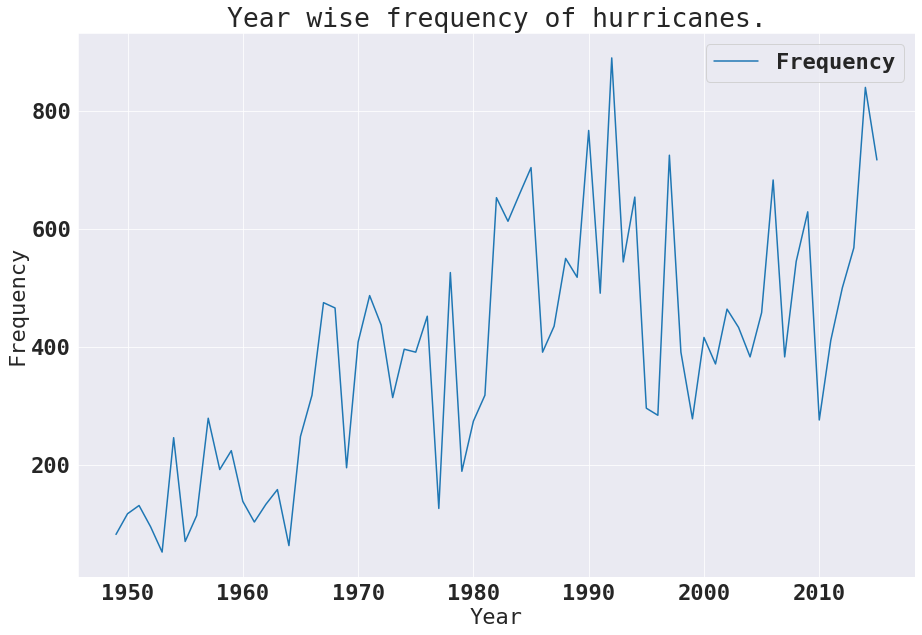

In [76]:
# year wise frequency of hurricanes
temp = data.groupby('Year').count().sort_values(by = 'Month', ascending = False)
plt.figure(figsize = (15,10))
sns.lineplot(x = temp.index, y = 'Month', data = temp, label = 'Frequency')
plt.ylabel('Frequency')
plt.title('Year wise frequency of hurricanes.')
plt.show()

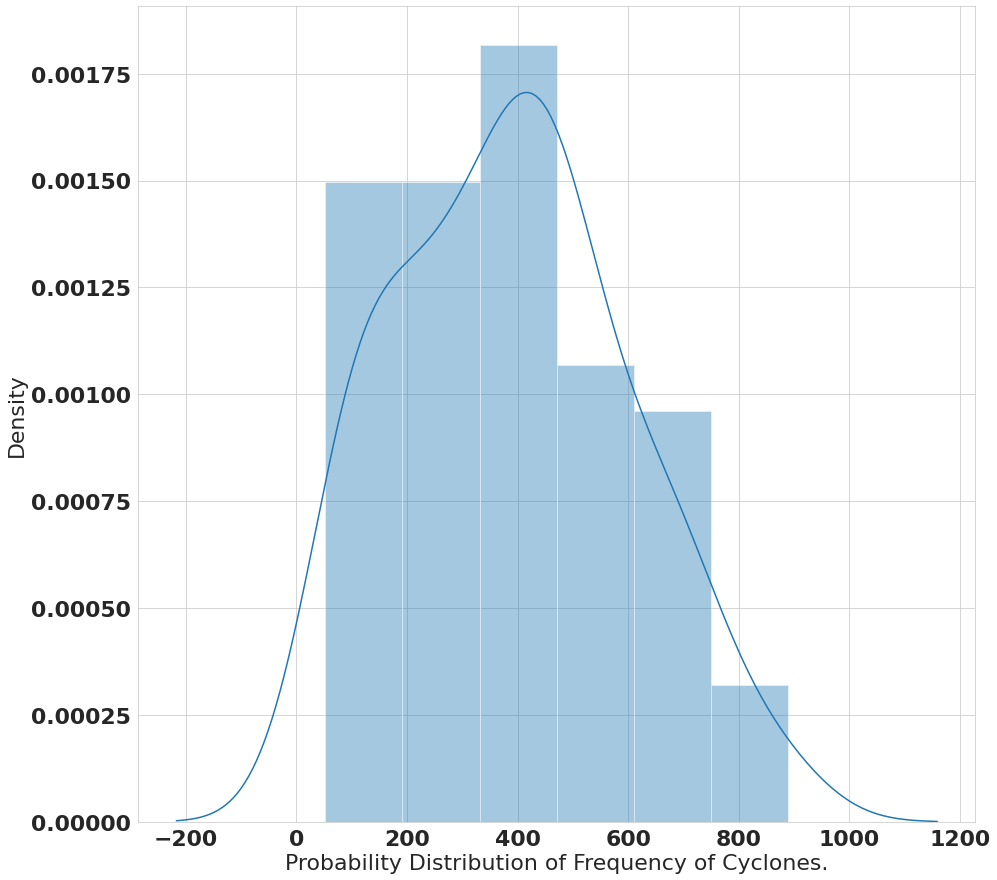

In [71]:
#probability distribution function of frequency
temp = data.groupby('Year').count().sort_values(by = 'Date' , ascending = False)
plt.figure(figsize=(15,15))
sns.distplot(temp['Date'].values , norm_hist = True , axlabel = 'Probability Distribution of Frequency of Cyclones.')

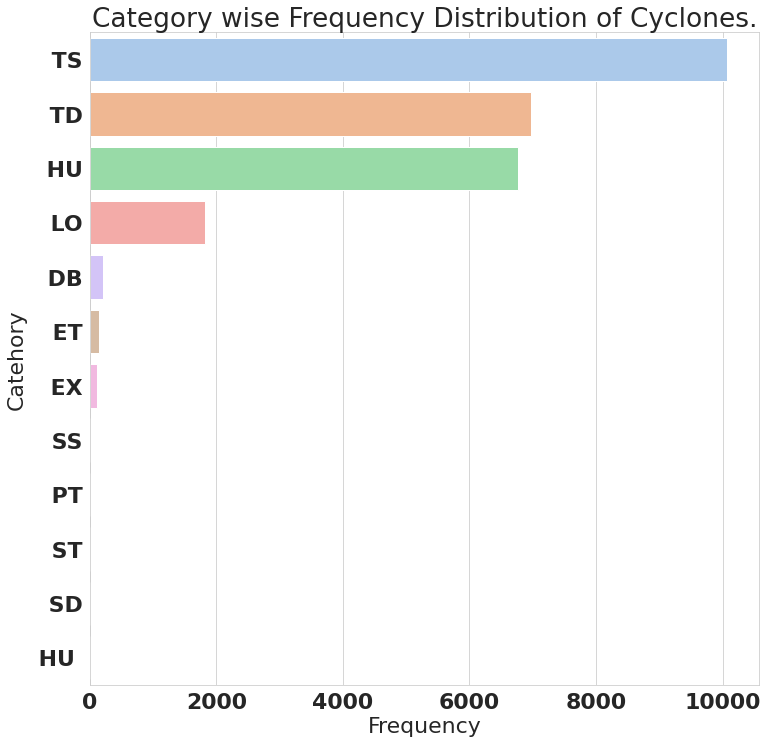

In [72]:
## Frequency of Cyclones by Category
# TD – Tropical cyclone of tropical depression intensity (< 34 knots)
# TS – Tropical cyclone of tropical storm intensity (34-63 knots)
# HU – Tropical cyclone of hurricane intensity (> 64 knots)
# EX – Extratropical cyclone (of any intensity)
# SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
# SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
# LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
# WV – Tropical Wave (of any intensity)
# DB – Disturbance (of any intensity)
temp = data.groupby('Status').count().sort_values(by = 'Date' , ascending = False)
fig , ax = plt.subplots()
fig.set_size_inches(12,12)
sns.barplot(y = list(temp.index) , x = 'Date' , data = temp, palette= 'pastel' )
plt.xlabel('Frequency')
plt.ylabel('Catehory')
plt.title('Category wise Frequency Distribution of Cyclones.')
plt.show()

Classification model

In [55]:
# 1. Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

dt = DecisionTreeClassifier(min_samples_leaf = 50, criterion = 'entropy')
# Set the dependent and independent variables.
x_train = data[['Latitude', 'Latitude_Hemisphere',
       'Longitude', 'Longitude_Hemisphere', 'Maximum Wind', 'Minimum Pressure',
       'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW',
       'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW',
       'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW',
       'High Wind NW' , 'Month' , 'Year']]
y_train = data['Status']

#perform the k-fold library
from sklearn.model_selection import KFold
kf = KFold(n_splits=10 , shuffle= True , random_state=42 )

dt_scores = []
dt_recall_scores = []
dt_precision_scores = []
for tr , ts in kf.split(x_train):
    xtr = x_train.loc[tr]
    ytr = y_train.loc[tr]
    xts = x_train.loc[ts]
    yts = y_train.loc[ts]
    dt.fit(xtr , ytr)
    y_pred = dt.predict(xts) 
    dt_scores.append(accuracy_score(yts, y_pred)) 
    dt_recall_scores.append(recall_score(yts , y_pred , average = 'weighted'))
    dt_precision_scores.append(precision_score(yts , y_pred , average = 'weighted'))
# dt.fit(x_train, y_train)
# y_pred = dt.predict(x_test)
# accuracy_score(y_test, y_pred)
dt_scr = {'accuracy' : np.mean(dt_scores) , 'recall': np.mean(dt_recall_scores) , 'precision' :  np.mean(dt_precision_scores) }
print('Accuracy score for Decision Tree is :' , dt_scr['accuracy'])
print('Recall score for Decision Tree is :' , dt_scr['recall'])
print('Precision score for Decision Tree is :' , dt_scr['precision'])    

Accuracy score for Decision Tree is : 0.9651068271145011
Recall score for Decision Tree is : 0.9651068271145011
Precision score for Decision Tree is : 0.9639969870825983


In [56]:
# Set the dependent and independent variables.
x_trainf = data[features.index[:5]]
y_train = data['Status']

# Perform the Kfold validation.

# Import the KFold library.
from sklearn.model_selection import KFold
kf = KFold(n_splits=10 , shuffle= True , random_state=42 )

dt_scores = []
dt_recall_scores = []
dt_precision_scores = []
for tr , ts in kf.split(x_trainf):
    xtr = x_trainf.loc[tr]
    ytr = y_train.loc[tr]
    xts = x_trainf.loc[ts]
    yts = y_train.loc[ts]
    dt.fit(xtr , ytr)
    y_pred = dt.predict(xts) 
    dt_scores.append(accuracy_score(yts, y_pred)) 
    dt_recall_scores.append(recall_score(yts , y_pred , average = 'weighted'))
    dt_precision_scores.append(precision_score(yts , y_pred , average = 'weighted'))
# dt.fit(x_train, y_train)
# y_pred = dt.predict(x_test)
# accuracy_score(y_test, y_pred)
dt_scr5 = {'accuracy' : np.mean(dt_scores) , 'recall': np.mean(dt_recall_scores) , 'precision' :  np.mean(dt_precision_scores) }
print('Accuracy score for Decision Tree is :' , dt_scr['accuracy'])
print('Recall score for Decision Tree is :' , dt_scr['recall'])
print('Precision score for Decision Tree is :' , dt_scr['precision'])

Accuracy score for Decision Tree is : 0.9651068271145011
Recall score for Decision Tree is : 0.9651068271145011
Precision score for Decision Tree is : 0.9639969870825983


As we can see the Top five features('Maximum Wind', 'Minimum Pressure', 'Latitude', 'Year', 'Longitude') give the same accuracy as when we get choosing all the features.

In [57]:
# 2. Random Forest
from sklearn.ensemble import RandomForestClassifier

# First I want to determine the important features.
rf = RandomForestClassifier(oob_score=True , n_estimators=1000)
rf.fit(x_train , y_train)
features = pd.Series(rf.feature_importances_ , index= x_train.columns).sort_values(ascending=False)
features

Maximum Wind            0.635491
Minimum Pressure        0.112214
Latitude                0.038982
Year                    0.038543
Longitude               0.036439
Low Wind NE             0.023195
Low Wind NW             0.019131
Low Wind SE             0.017516
High Wind NE            0.013761
Month                   0.011495
Low Wind SW             0.010619
High Wind SE            0.009469
High Wind NW            0.008428
High Wind SW            0.005830
Moderate Wind NE        0.004752
Moderate Wind SE        0.004406
Moderate Wind SW        0.004131
Moderate Wind NW        0.003350
Longitude_Hemisphere    0.002250
Latitude_Hemisphere     0.000000
dtype: float64

In [58]:
# Here instead of cross validation we will be using oob score as a measure of accuracy.
# I will hyper tuning the parameter: No of Trees.

trees  = [10, 20 , 50, 100,200,500,1000,1200]
maxn_five = {}
maxn = {}
for i in trees:
    rf = RandomForestClassifier(n_estimators=i , oob_score=True)
    rf.fit(x_trainf , y_train)
    print('Obb Score for {x} trees: and taking top five features '.format(x = i) , rf.oob_score_)
    maxn_five[i] = rf.oob_score_
    rf.fit(x_trainf , y_train)
    print('Obb Score for {x} trees: and taking all the features '.format(x = i) , rf.oob_score_)
    maxn[i] = rf.oob_score_

Obb Score for 10 trees: and taking top five features  0.9671729731797835
Obb Score for 10 trees: and taking all the features  0.9670581933657267
Obb Score for 20 trees: and taking top five features  0.9802196120442285
Obb Score for 20 trees: and taking all the features  0.9802578719822473
Obb Score for 50 trees: and taking top five features  0.9824386884493247
Obb Score for 50 trees: and taking all the features  0.980793511114512
Obb Score for 100 trees: and taking top five features  0.9825534682633814
Obb Score for 100 trees: and taking all the features  0.9832038872097028
Obb Score for 200 trees: and taking top five features  0.9827447679534759
Obb Score for 200 trees: and taking all the features  0.9832421471477216
Obb Score for 500 trees: and taking top five features  0.9832038872097028
Obb Score for 500 trees: and taking all the features  0.9828978077055515
Obb Score for 1000 trees: and taking top five features  0.9831656272716838
Obb Score for 1000 trees: and taking all the featu

In [59]:
# Split the data into training and testing.
x_trains , x_tests , y_trains, y_tests  = train_test_split(x_trainf, y_train, test_size=0.33, random_state=42)
# Set n to the feature of maximum oob score.
n = 0
for i in maxn_five:
    if max(maxn_five.values()) == maxn_five[i]:
        n= i
# Set n_estimators to n.
rf = RandomForestClassifier(oob_score=True , n_estimators=n)
rf.fit(x_trains , y_trains)
y_pred_rf = rf.predict(x_tests[features.index[:5]])
scores_rf = {'accuracy': accuracy_score(y_tests , y_pred_rf) ,'recall' : recall_score(y_tests , y_pred_rf , average='weighted') ,'precision' : precision_score(y_tests , y_pred_rf , average='weighted') }
print('Scores for Random Forest with n = ' , n , ' and using features ',  features.index[:5] , ' are : ')
print('Accuracy: ' , scores_rf['accuracy'])
print('Recall: ' , scores_rf['recall'])
print('Precision: ' , scores_rf['precision'])

# n_All = 0
# for i in maxn:
#     if max(maxn.values()) == maxn[i]:
#         n_All= i
# # Set n_estimators to n.
# rf = RandomForestClassifier(oob_score=True , n_estimators=n_All)
# rf.fit(x_train , y_train)
# y_pred_rf_all = rf.predict(x_test)
# scores_rf_all = {'accuracy': accuracy_score(y_test , y_pred_rf) ,'recall' : recall_score(y_test , y_pred_rf , average='weighted') ,'precision' : precision_score(y_test , y_pred_rf , average='weighted') }
# print('Scores for Random Forest with n = ' , n_All , ' and using all features ' , ' are : ')
# print('Accuracy: ' , scores_rf_all['accuracy'])
# print('Recall: ' , scores_rf_all['recall'])
# print('Precision: ' , scores_rf_all['precision'])


Scores for Random Forest with n =  1200  and using features  Index(['Maximum Wind', 'Minimum Pressure', 'Latitude', 'Year', 'Longitude'], dtype='object')  are : 
Accuracy:  0.9813354973336424
Recall:  0.9813354973336424
Precision:  0.9808839322112932


In [60]:
#3. Naive Bayes Algorithm
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb5 = GaussianNB()
acc_s = [] 
rcl_s = [] 
ps_scr = []
acc_s_5 = [] 
rcl_s_5 = [] 
ps_scr_5 = []
for tr, ts in kf.split(x_train):
    xtr = x_train.loc[tr]
    ytr = y_train.loc[tr]
    xts = x_train.loc[ts]
    yts = y_train.loc[ts]
    xtr5 = x_trainf.loc[tr]
    xts5 = x_trainf.loc[ts]

    
    # Accuracy , Precision and recall with all features.
   
    nb.fit(xtr , ytr)
    y_nb_pred = nb.predict(xts)
    acc_s.append(accuracy_score(yts , y_nb_pred))
    rcl_s.append(recall_score(yts , y_nb_pred , average = 'weighted'))
    ps_scr.append(precision_score(yts , y_nb_pred , average = 'weighted'))
    
#     Accuracy , Precision and recall with top five features.
    nb5.fit(xtr5 , ytr)
    y_nb5_pred = nb5.predict(xts5)
    acc_s_5.append(accuracy_score(yts , y_nb5_pred))
    rcl_s_5.append(recall_score(yts , y_nb5_pred , average = 'weighted'))
    ps_scr_5.append(precision_score(yts , y_nb5_pred , average = 'weighted'))
    
nb_scores = {'accuracy':np.mean(acc_s) , 'recall':np.mean(rcl_s) , 'precision':np.mean(ps_scr)}
nb5_scores = {'accuracy':np.mean(acc_s_5) , 'recall':np.mean(rcl_s_5) , 'precision':np.mean(ps_scr_5)}
print('Naive Bayes results for top five features for Accuracy ' , nb5_scores['accuracy'] , 'Recall: ' , nb5_scores['recall'], 'and Precision: ' , nb5_scores['precision'] )
print('Naive Bayes results for all features for Accuracy ' , nb_scores['accuracy'] , 'Recall: ' , nb_scores['recall'], 'and Precision: ' , nb_scores['precision'] )

Naive Bayes results for top five features for Accuracy  0.9267697472849982 Recall:  0.9267697472849982 and Precision:  0.9444534250577468
Naive Bayes results for all features for Accuracy  0.16114908360908659 Recall:  0.16114908360908659 and Precision:  0.7849567692891887


In [61]:
# Import SVM.
from sklearn import svm
mdl5 = svm.SVC()
acc_s_5 = [] 
rcl_s_5 = [] 
ps_scr_5 = []

# Split the data into train and test.
xtr5, xts5 , ytr , yts = train_test_split(x_trainf , y_train , test_size = 0.25 , random_state = 42)

# Train the model.
mdl5.fit(xtr5 , ytr)
y_mdl5_pred = nb5.predict(xts5)
acc_s_5.append(accuracy_score(yts , y_mdl5_pred))
rcl_s_5.append(recall_score(yts , y_mdl5_pred , average = 'weighted'))
ps_scr_5.append(precision_score(yts , y_mdl5_pred , average = 'weighted'))

# for tr, ts in kf.split(x_train):
#     ytr = y_train.loc[tr]
#     yts = y_train.loc[ts]
#     xtr5 = x_trainf.loc[tr]
#     xts5 = x_trainf.loc[ts]

# #   Accuracy , Precision and recall with top five features.
#     mdl5.fit(xtr5 , ytr)
#     y_mdl5_pred = nb5.predict(xts5)
#     acc_s_5.append(accuracy_score(yts , y_mdl5_pred))
#     rcl_s_5.append(recall_score(yts , y_mdl5_pred , average = 'weighted'))
#     ps_scr_5.append(precision_score(yts , y_mdl5_pred , average = 'weighted'))
    
svm_scores = {'accuracy':np.mean(acc_s_5) , 'recall':np.mean(rcl_s_5) , 'precision':np.mean(ps_scr_5)}
print('SVM results for top five features for Accuracy ' , svm_scores['accuracy'] , 'Recall: ' , svm_scores['recall'], 'and Precision: ' , svm_scores['precision'] )

SVM results for top five features for Accuracy  0.9282325937260902 Recall:  0.9282325937260902 and Precision:  0.9464563272916006


We can see that the overall score with top five features is significantly greater than the overall score with all the features. Hence , we can see that feature selection is very important for SVM.

In [62]:
## Comparing the algorithms.
res = {'DecisionTree':dt_scr5['accuracy'] , 'RandomForest': scores_rf['accuracy'] , 'GaussianNB': nb5_scores['accuracy'] , 'SVM':svm_scores['accuracy']}
max_res = max(res.values())
max_index = ''
for i in res:
    if res[i] == max_res:
        max_index = i
print('The most effictive algorithm is :' , max_index , 'with accuracy: ' , res[max_index])

The most effictive algorithm is : RandomForest with accuracy:  0.9813354973336424
